## CMI-PB Hackathon: Sparse Autoencoder Model
### This script prepares data, defines a sparse autoencoder model, and performs training and evaluation on antibody response data.


## Importing Libraries and Seed Setup

In [1]:
# %%
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.model_selection import train_test_split
import optuna

print("Successfully loaded the packages")

Successfully loaded the packages


In [2]:

# Set a fixed seed for reproducibility
seed = 42

# Python's built-in random module
random.seed(seed)

# NumPy random generator
np.random.seed(seed)

# PyTorch random generator for CPU
torch.manual_seed(seed)

# PyTorch random generator for GPU (if using CUDA)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Ensures deterministic behavior for certain CUDA operations (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## 2. Set Paths and Load Data

In [3]:
# %%
# Set data path
data_path = r"C:/Users/divyas/Documents/hackathons/CMI_PB/Tasks/Task_IGg_PT/Data_Task_IGg_PT/"

# Load data
X_train = pd.read_csv(data_path + "abtiter_data_X_train.csv", index_col=0)
y_train = pd.read_csv(data_path + "abtiter_data_y_train.csv", index_col=0).values.ravel()
X_test = pd.read_csv(data_path + "abtiter_data_X_test.csv", index_col=0)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")



X_train shape: (111, 42)
y_train shape: (111,)
X_test shape: (54, 42)


In [4]:
# %% [markdown]
# ## 3. Data Preprocessing

# %%
def calculate_age(row):
    """Calculate age from 'year_of_birth' and 'date_of_boost'."""
    if pd.notnull(row['year_of_birth']) and pd.notnull(row['date_of_boost']):
        return row['date_of_boost'].year - row['year_of_birth'].year
    return None

def preprocess_data(X_train, X_test):
    # Convert dates
    X_train['date_of_boost'] = pd.to_datetime(X_train['date_of_boost'], errors='coerce')
    X_test['date_of_boost'] = pd.to_datetime(X_test['date_of_boost'], errors='coerce')
    X_train['year_of_birth'] = pd.to_datetime(X_train['year_of_birth'], errors='coerce')
    X_test['year_of_birth'] = pd.to_datetime(X_test['year_of_birth'], errors='coerce')

    # Calculate age
    X_train['age'] = X_train.apply(calculate_age, axis=1)
    X_test['age'] = X_test.apply(calculate_age, axis=1)

    # Map categorical features
    X_train['infancy_vac'] = X_train['infancy_vac'].map({'wP': 0, 'aP': 1})
    X_train['biological_sex'] = X_train['biological_sex'].map({'Female': 0, 'Male': 1})
    X_test['infancy_vac'] = X_test['infancy_vac'].map({'wP': 0, 'aP': 1})
    X_test['biological_sex'] = X_test['biological_sex'].map({'Female': 0, 'Male': 1})

    # One-hot encode 'race' after combining datasets for consistency
    X_combined = pd.concat([X_train, X_test], axis=0)
    X_combined = pd.get_dummies(X_combined, columns=['race'], drop_first=False)
    X_train_new = X_combined.loc[X_train.index]
    X_test_new = X_combined.loc[X_test.index]
    
    # Drop unneeded metadata columns
    metadata_columns = ['dataset', 'timepoint', 'date_of_boost', 'year_of_birth', 'ethnicity', 'visit', 'specimen_type']
    X_train_new = X_train_new.drop(columns=metadata_columns, errors='ignore')
    X_test_new = X_test_new.drop(columns=metadata_columns, errors='ignore')

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_new)
    X_test_scaled = scaler.transform(X_test_new)

    return X_train_scaled, X_test_scaled

# Preprocess data
X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)



In [5]:
# ## 4. Define Sparse Autoencoder

# %%
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, sparsity_weight=10):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.sparsity_weight = sparsity_weight

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded, encoded

    def sparsity_loss(self, encoded):
        return self.sparsity_weight * torch.mean(torch.abs(encoded))



In [6]:
def train_autoencoder(model, train_loader, val_loader, optimizer, num_epochs=500):
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        rec_loss = 0.0
        
        for batch_data, _ in train_loader:
            optimizer.zero_grad()
            reconstructed, encoded = model(batch_data)
            reconstruction_loss = F.mse_loss(reconstructed, batch_data)
            sparsity_loss = model.sparsity_loss(encoded)
            total_loss = reconstruction_loss + sparsity_loss
            total_loss.backward()
            optimizer.step()
            
            # Track training loss
            epoch_loss += total_loss.item()
            rec_loss += reconstruction_loss.item()

        # Calculate average losses per epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        avg_rec_loss = rec_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_rec_loss = 0.0

        with torch.no_grad():
            for batch_data, _ in val_loader:
                reconstructed, encoded = model(batch_data)
                reconstruction_loss = F.mse_loss(reconstructed, batch_data)
                sparsity_loss = model.sparsity_loss(encoded)
                total_loss = reconstruction_loss + sparsity_loss

                # Track validation loss
                val_loss += total_loss.item()
                val_rec_loss += reconstruction_loss.item()

        # Calculate average validation losses per epoch
        avg_val_loss = val_loss / len(val_loader)
        avg_val_rec_loss = val_rec_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Logging
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Total Loss: {avg_epoch_loss:.4f}, Train Reconstruction Loss: {avg_rec_loss:.4f}, "
              f"Val Total Loss: {avg_val_loss:.4f}, Val Reconstruction Loss: {avg_val_rec_loss:.4f}")

    return train_losses, val_losses


In [19]:
# Hyperparameters
input_dim = X_train_scaled.shape[1]
hidden_dim = 128        # Change to 64 or 256 if needed
sparsity_weight = 10    # Adjust this for sparsity control
lr = 1e-4               # Try 5e-4 or 1e-5 if necessary
num_epochs = 500        # Adjust as needed based on convergence


# Initialize the model with the set hyperparameters
model = SparseAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim, sparsity_weight=sparsity_weight)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Split your data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train, test_size=0.1, random_state=42
)

# X_train_split.shape
# X_val_split.shape
# y_train_split.type()
# y_val_split.shape

# Convert the split data into tensors
X_train_tensor = torch.tensor(X_train_split, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_split, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_split, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_split, dtype=torch.float32)

# Set up DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
x=next(iter(train_loader))
# print(x[1].shape)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Train the model and validate
train_losses, val_losses = train_autoencoder(model, train_loader, val_loader, optimizer, num_epochs=num_epochs)


Epoch [1/500], Train Total Loss: 3.3632, Train Reconstruction Loss: 1.0950, Val Total Loss: 2.4991, Val Reconstruction Loss: 0.6667
Epoch [2/500], Train Total Loss: 3.4602, Train Reconstruction Loss: 1.1979, Val Total Loss: 2.4934, Val Reconstruction Loss: 0.6655
Epoch [3/500], Train Total Loss: 3.1907, Train Reconstruction Loss: 1.0293, Val Total Loss: 2.4879, Val Reconstruction Loss: 0.6644
Epoch [4/500], Train Total Loss: 3.3562, Train Reconstruction Loss: 1.1596, Val Total Loss: 2.4823, Val Reconstruction Loss: 0.6633
Epoch [5/500], Train Total Loss: 2.9558, Train Reconstruction Loss: 0.9355, Val Total Loss: 2.4760, Val Reconstruction Loss: 0.6620
Epoch [6/500], Train Total Loss: 2.9662, Train Reconstruction Loss: 0.9681, Val Total Loss: 2.4698, Val Reconstruction Loss: 0.6609
Epoch [7/500], Train Total Loss: 3.2380, Train Reconstruction Loss: 1.0838, Val Total Loss: 2.4634, Val Reconstruction Loss: 0.6597
Epoch [8/500], Train Total Loss: 3.1908, Train Reconstruction Loss: 1.0732, 

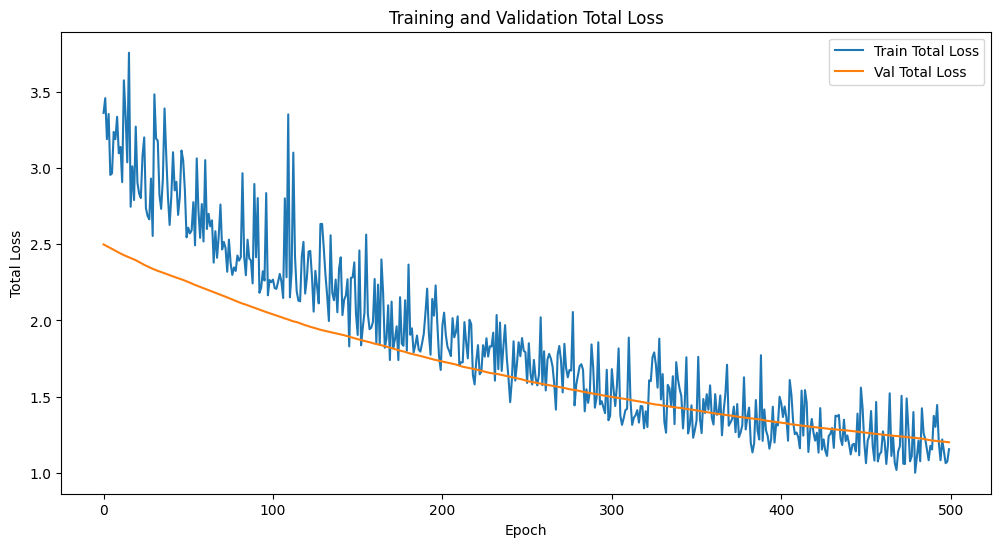

In [21]:
# Plotting the losses
plt.figure(figsize=(12, 6))

# Plot total loss
plt.plot(train_losses, label="Train Total Loss")
plt.plot(val_losses, label="Val Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Training and Validation Total Loss")
plt.legend()
plt.show()



In [9]:
# def optimize_autoencoder(trial, X_train_tensor):
#     input_dim = X_train_tensor.shape[1]
#     hidden_dim = trial.suggest_int("hidden_dim", 64, 128)
#     sparsity_weight = trial.suggest_int("sparsity_weight", 1e0, 1e1)
#     lr = trial.suggest_int("lr", 1e-5, 1e-4)

#     model = SparseAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim, sparsity_weight=sparsity_weight)
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     batch_size = 32
#     dataset = TensorDataset(X_train_tensor)
#     train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#     train_losses, _ = train_autoencoder(model, train_loader, train_loader, optimizer, num_epochs=500)
#     return train_losses[-1]

# # Optuna optimization function
# def run_optuna(X_train_tensor):
#     study = optuna.create_study(direction="minimize")
#     study.optimize(lambda trial: optimize_autoencoder(trial, X_train_tensor), n_trials=100)
#     print("Best hyperparameters:", study.best_params)
#     return study.best_params

# # # Running the optimization
# # X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# # best_params = run_optuna(X_train_tensor)
# # print("Optimized hyperparameters:", best_params)


In [10]:
# from torch.utils.data import random_split

# # Convert full training data to tensors
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Ensure y_train is converted to tensor

# # Combine features and labels into a single dataset
# full_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# # Calculate split sizes for training (90%) and validation (10%)
# train_size = int(0.9 * len(full_train_dataset))
# val_size = len(full_train_dataset) - train_size

# # Randomly split the full training dataset into train and validation sets
# train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# # Create DataLoaders for the train and validation datasets
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Step 1: Extract features (X) from train_dataset
# train_features = torch.stack([data[0] for data in train_dataset])

# # Run Optuna for Hyperparameter Optimization using extracted features
# best_params = run_optuna(train_features)

# # %% [markdown]
# # ## 5. Set Up Model and Train with Best Hyperparameters on Training Subset

# # Set up model with optimized hyperparameters
# model = SparseAutoencoder(input_dim=X_train_tensor.shape[1], hidden_dim=best_params["hidden_dim"],
#                           sparsity_weight=best_params["sparsity_weight"])
# optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

# # Train model on train_loader and validate on val_loader
# train_losses, val_losses = train_autoencoder(model, train_loader, val_loader, optimizer, num_epochs=500)

# # %% [markdown]
# # ## 6. Encode Train and Validation Data for Random Forest Regression

# # Convert train and validation data into encoded form for regression
# with torch.no_grad():
#     model.eval()
#     X_train_encoded, _ = model(X_train_tensor[train_dataset.indices])  # Indices for train subset
#     X_val_encoded, _ = model(X_train_tensor[val_dataset.indices])      # Indices for validation subset

# # Convert encoded representations to numpy for Random Forest
# X_train_encoded_np = X_train_encoded.detach().numpy()
# X_val_encoded_np = X_val_encoded.detach().numpy()
# y_train_np = y_train_tensor[train_dataset.indices].numpy()
# y_val_np = y_train_tensor[val_dataset.indices].numpy()

# # %% [markdown]
# # ## 7. Train Random Forest Regressor and Evaluate RMSE on Validation Set

# # Train RandomForest on encoded training subset
# regressor = RandomForestRegressor(n_estimators=500, random_state=42)
# regressor.fit(X_train_encoded_np, y_train_np)

# # Make predictions on the validation subset and calculate RMSE
# y_pred_val = regressor.predict(X_val_encoded_np)
# val_rmse = mean_squared_error(y_val_np, y_pred_val, squared=False)
# print(f"Validation RMSE: {val_rmse:.4f}")


In [11]:
# plt.scatter(y_val_np, y_pred_val, alpha=0.7)
# plt.xlabel("Actual IgG_PT (Validation)")
# plt.ylabel("Predicted IgG_PT (Validation)")
# plt.title("Validation Set: Predicted vs Actual IgG_PT")
# plt.plot([y_val_np.min(), y_val_np.max()], [y_val_np.min(), y_val_np.max()], 'k--')
# plt.show()
# np.corrcoef(y_val_np, y_pred_val)

In [12]:
# from scipy.stats import spearmanr

# # Assuming y_true and y_pred are your true and predicted values as 1D arrays
# # Replace these with your actual values
# y_true = y_val_np  # e.g., y_train or y_test
# y_pred = y_pred_val # e.g., model.predict(X_test)

# # Calculate Spearman's rank correlation
# spearman_corr, _ = spearmanr(y_true, y_pred)

# print(f"Spearman's Rank Correlation Coefficient: {spearman_corr:.4f}")


In [13]:
# # Assuming `y_true` and `y_pred` are numpy arrays or similar
# def calculate_normalized_error_norm(y_true, y_pred):
#     # Calculate the numerator: ||y_true - y_pred||
#     error_norm = np.linalg.norm(y_true - y_pred)
#     # Calculate the denominator: ||y_true||
#     true_norm = np.linalg.norm(y_true)
#     # Calculate the normalized error norm
#     normalized_error_norm = error_norm / true_norm
#     return normalized_error_norm

# y_true = y_val_np  # e.g., y_train or y_test
# y_pred = y_pred_val # e.g., model.predict(X_test)

# normalized_error = calculate_normalized_error_norm(y_true, y_pred)  # Replace with actual data
# print(f"Normalized Error Norm: {normalized_error:.4f}")



In [14]:
# # %% [markdown]
# # ## 8. Retrain Model on Full Training Data and Make Predictions on Test Set

# # %%
# # Retrain Sparse Autoencoder on full training data
# full_train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=32, shuffle=True)
# model = SparseAutoencoder(input_dim=X_train_tensor.shape[1], hidden_dim=best_params["hidden_dim"],
#                           sparsity_weight=best_params["sparsity_weight"])
# optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

# # Train the autoencoder on the entire training data
# train_losses, _ = train_autoencoder(model, full_train_loader, full_train_loader, optimizer, num_epochs=500)

# # Encode the entire training set and test set using the re-trained autoencoder
# with torch.no_grad():
#     _, X_train_encoded_full = model(X_train_tensor)
#     X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)  # Ensure test tensor is compatible
#     _, X_test_encoded = model(X_test_tensor)

# # Convert encoded data to numpy arrays for Random Forest
# X_train_encoded_full_np = X_train_encoded_full.detach().numpy()
# X_test_encoded_np = X_test_encoded.detach().numpy()

# # Train RandomForest on the re-encoded entire training data
# regressor = RandomForestRegressor(n_estimators=500, random_state=42)
# regressor.fit(X_train_encoded_full_np, y_train.ravel())  # Flatten y_train for RandomForest

# # Make predictions on the test data using the re-trained Random Forest model
# y_pred_test = regressor.predict(X_test_encoded_np)
# print("Test predictions:", y_pred_test)


In [15]:
# # %% [markdown]
# # ## 10. Retrain Model on the Entire Training Set

# # %%
# # Concatenate training and validation sets for final training
# full_X_train_tensor = torch.tensor(np.vstack([X_train_scaled, X_test_scaled]), dtype=torch.float32)
# full_y_train = np.concatenate([y_train, y_train])  # Assuming y_train and y_test are identical targets for final training

# # Initialize the model with best parameters from Optuna
# final_model = SparseAutoencoder(input_dim=full_X_train_tensor.shape[1], 
#                                 hidden_dim=best_params["hidden_dim"], 
#                                 sparsity_weight=best_params["sparsity_weight"])
# final_optimizer = optim.Adam(final_model.parameters(), lr=best_params["lr"])

# # Set up final DataLoader
# full_train_loader = DataLoader(TensorDataset(full_X_train_tensor), batch_size=32, shuffle=True)

# # Final training on the combined training set
# final_train_losses, _ = train_autoencoder(final_model, full_train_loader, full_train_loader, final_optimizer, num_epochs=500)

# # Plot final training loss for tracking
# plt.plot(final_train_losses, label="Final Train Total Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Total Loss")
# plt.title("Final Training Loss")
# plt.legend()
# plt.show()



In [16]:
# # %% [markdown]
# # ## 12. Test Set Predictions and Evaluation

# # %%
# # Save predictions for analysis
# y_test_pred_df = pd.DataFrame(y_test_pred, index=X_test.index, columns=["Predicted_IgG_PT"])

# # Display first few predictions
# print("Test Set Predictions:\n", y_test_pred_df.head())

# # Plot predictions for a visual check
# plt.figure(figsize=(10, 6))
# plt.hist(y_test_pred, bins=20, color="skyblue", edgecolor="black")
# plt.xlabel("Predicted IgG_PT Values")
# plt.ylabel("Frequency")
# plt.title("Distribution of Predicted IgG_PT Values on Test Set")
# plt.show()

# # Save predictions to CSV if needed
# y_test_pred_df.to_csv(data_path + "final_test_predictions.csv")
